# Summary
This code will compare stock market info from the US and Korea to the price of bitcoin and to the "impressions" of bitcoin on Google trends. For Korea, the KOSDAQ index is used as it is the most comprabable to the NASDAQ. Both of these markets indicate the general "health" of the respective country's economy. Regression techniques will be run on the data in order to predict the price of bitcoin on the following day. A webapp http://mohibtc.pythonanywhere.com/ will ask the user for what price they bought their bitcoin at and what today's NASDAQ, KOSDAQ, and what this week's Google Trends impression is. If the model predicts tomorrow's price to be less than what the user bought bitcoin for, it will instruct them to sell. If the model predict's tomorrow's price to be more than what the user bought bitcoin for, it will instruct them to buy more. Multiple regressions will be used to determine the best model.

Closing price of BTC on this exchange is 24:00 PM UTC which is 8:00 EST; opening at 12 UTC
NYSE closes at  is 21:00 UTC which is 4PM EST; opens at 14:30 UTC
Shanghai stock exchange closes at 6:00 UTC which is 2AM EST; opens at 0 UTC
With a 12 hour difference, the KOSDAQ market has run it's daily course before the NYSE even opens.
The two markets are never open at the same time so I will use their listed closing price for a given date.
BTC is only tracked for its closing price and acquiring a dataset with all the values of BTC matched up to closing times of the SSE and the NYSE would be extremely difficult for a non-enterprise. So I will stick with BTC closing price of midnight UTC, knowing that this does not match the price of BTC when either market closed, but should still be reasonably correlated.
NASDAQ and KOSDAQ were chosen because Korea makes up a significant portion of cryptocurrency trailing behind the U.S. Japan actually trades the most, but their market has very irregular open and close times, in general does not line up with the NYSE for trading days, and most importantly uses the Nikkei 225 index which is only comparable to the U.S. Dow Jones. However, the similarity between the NASDAQ and KOSDAQ is far more than the Nikkei 225 and the Dow Jones so Korea was used in place of korea.

To summarize,
US and South Korea are leaders in BTC trading. Japan is the most involved, but their Nikkei 225 market does not line up with the US market because of both the time difference and operating hours (our market is technically open during their weekends) leading to the data being full of holes. The other leader in trading is USDT, which is Tether, another crypto and not reflective of a specific country. So that leaves only the US and South Korea to compare.

In [2]:
# read data into a DataFrame and importing all regression related libraries.
import pandas as pd
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
import random
import json
import statsmodels.api as sm
from sklearn.cross_validation import KFold
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier as RF
from sklearn.neighbors import KNeighborsClassifier as KNN
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.utils import shuffle
from sklearn.metrics import roc_curve, auc
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_validation import train_test_split

import sys
!{sys.executable} -m pip install pytrends

from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360)

C:\Users\tuleg\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
C:\Users\tuleg\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [3]:

#taken from https://www.coindesk.com/price/
dfBTC=pd.read_csv("/Users/tuleg/Documents/python-introduction-MohiAhmed/coindesk-bpi-USD-close_data-2017-05-07_2018-05-07.csv")
dfBTC.head()
#Count_Row=dfBTC.shape[0]
len(dfBTC)

368

In [4]:
#taken from https://finance.yahoo.com/quote/%5EKQ11/history?period1=1493870400&period2=1525406400&interval=1d&filter=history&frequency=1d
dfSSE=pd.read_csv("/Users/tuleg/Documents/python-introduction-MohiAhmed/KOSDAQ3.csv")
dfSSE.head()
#need to convert KRW to USD
#Count_Row2=dfSSE.shape[0]
len(dfSSE)


242

In [5]:
dfNAS=pd.read_csv("/Users/tuleg/Documents/python-introduction-MohiAhmed/NASDAQ3.csv")
dfNAS.head()
#Count_Row3=dfNAS.shape[0]
len(dfNAS)

251

In [6]:
#Filtered dataset
#dfdata=pd.read_csv("/Users/tuleg/Documents/python-introduction-MohiAhmed/data.csv")

In [7]:
#len(dfdata)

In [8]:
#dfdata.head()


In [9]:
#Using an api to get google trends data for the word "bitcoin"
from pytrends.request import TrendReq

pytrends = TrendReq(hl='en-US', tz=360) #set to english and central standard time, but cst not necessary

In [10]:
#key word for google trends to look for is "bitcoin"

keyword = 'Bitcoin'
pytrend = TrendReq(hl='en-US')

#google trends only gives you daily data in 90 day intervals (beyond 90 days it outputs weekly), so need to repeat this 3 more times
#first 90 day impression interval, starting data point is 5/8/2017 to match previously collected data

pytrend.build_payload(kw_list=[keyword], timeframe='2017-05-08 2017-08-01', geo='', gprop='')

#Interest over time, (popularity of the keyword 'Bitcoin')
interest_over_time_df = pytrend.interest_over_time()
print('First 90 days Head')
print(interest_over_time_df.head())
print('First 90 days Tail')
print(interest_over_time_df.tail())

#second 90 day impression interval
pytrend2= TrendReq(hl='en-US')
pytrend2.build_payload(kw_list=[keyword], timeframe='2017-08-02 2017-11-02', geo='', gprop='')
interest_over_time_df2 = pytrend2.interest_over_time()
print('Second 90 days Head')
print(interest_over_time_df2.head())
print('Second 90 days Tail')
print(interest_over_time_df2.tail())

#third 90 day impression interval
pytrend3= TrendReq(hl='en-US')
pytrend3.build_payload(kw_list=[keyword], timeframe='2017-11-03 2018-02-03', geo='', gprop='')
interest_over_time_df3 = pytrend3.interest_over_time()
print('Third 90 days Head')
print(interest_over_time_df3.head())
print('Third 90 days Tail')
print(interest_over_time_df3.tail())

#fourth 90 day impressional interval
pytrend4= TrendReq(hl='en-US')
pytrend4.build_payload(kw_list=[keyword], timeframe='2018-02-04 2018-05-04', geo='', gprop='')
interest_over_time_df4 = pytrend4.interest_over_time()
print('Fourth 90 days Head')
print(interest_over_time_df4.head())
print('Fourth 90 days Tail')
print(interest_over_time_df4.tail())

First 90 days Head
            Bitcoin  isPartial
date                          
2017-05-08       29      False
2017-05-09       37      False
2017-05-10       34      False
2017-05-11       38      False
2017-05-12       44      False
First 90 days Tail
            Bitcoin  isPartial
date                          
2017-07-28       45      False
2017-07-29       37      False
2017-07-30       37      False
2017-07-31       46      False
2017-08-01       80      False
Second 90 days Head
            Bitcoin  isPartial
date                          
2017-08-02       49      False
2017-08-03       35      False
2017-08-04       32      False
2017-08-05       40      False
2017-08-06       34      False
Second 90 days Tail
            Bitcoin  isPartial
date                          
2017-10-29       44      False
2017-10-30       53      False
2017-10-31       61      False
2017-11-01       76      False
2017-11-02      100      False
Third 90 days Head
            Bitcoin  isPartial
date

In [11]:
#concatenating the four 90 day intervals to achieve ~1 year of daily impressions for key word "Bitcoin"
Impressionframes = [interest_over_time_df, interest_over_time_df2, interest_over_time_df3, interest_over_time_df4]

Impressions = pd.concat(Impressionframes)
print('Impressions Head')
print(Impressions.head())
print('Impressions Tail')
print(Impressions.tail())

#Notice the head of Impressions matches the head of first 90 day interval and tail of Impressions match tail of fourth interval

Impressions Head
            Bitcoin  isPartial
date                          
2017-05-08       29      False
2017-05-09       37      False
2017-05-10       34      False
2017-05-11       38      False
2017-05-12       44      False
Impressions Tail
            Bitcoin  isPartial
date                          
2018-04-30       16      False
2018-05-01       16      False
2018-05-02       16      False
2018-05-03       17      False
2018-05-04       17      False


Unfortunately, this is NOT accurate. Google assigned a 1-100 score to each 90 day interval, so when combined there are multiple '100' 'peaks' (one for each 90 days) when there should only be one instance of maximum popularity/impressions. In order to combine them and correct for this, I will use :https://github.com/knguyen1/WPF.Google.Trends.Combinator and http://erikjohansson.blogspot.com/2013/04/how-to-get-daily-google-trends-data-for.html which uses the previously obtained daily data and then looks at the values for the weekly data and adjusts the values of the daily data.

For May 8, 2017 to May 4, 2018 Google Trends will give you weekly popularity
For 90 day intervals, it will give you daily popularity, but if concatenate them there will be spikes of "100" where there shouldn't be. (Refer to presentation slide 7)

In [12]:
#ignore
#import csv

#csvfile = "/Users/tuleg/Documents/Columbia University/Semester 2/Data Science/dailyimpressions"

#with open(csvfile, "w") as output:
 #   writer = csv.writer(output, lineterminator='\n')
  #  for val in Impressions:
   #     writer.writerow([val])    

In [13]:
#Final dataset from 5/8/2017 to 5/04/2018
#CSV: Date, NASDAQ, KOSDAQ, BTC, Adjusted Impressions
df=pd.read_csv("/Users/tuleg/Documents/python-introduction-MohiAhmed/data2.csv")
print(df.head())
print(df.tail())

        Date  NASDAQ   KOSDAQ  Adj Impressions     BTC
0   5/8/2017  6102.7  0.59835        10.000000  1639.3
1  5/10/2017  6129.1  0.59769        11.666667  1756.8
2  5/11/2017  6116.0  0.60225        12.333333  1807.4
3  5/12/2017  6121.2  0.59867        14.666667  1677.0
4  5/15/2017  6149.7  0.60020        18.000000  1697.4
          Date  NASDAQ   KOSDAQ  Adj Impressions     BTC
230  4/27/2018  7119.8  0.82444        17.377778  8978.3
231  4/30/2018  7066.3  0.81463        16.355556  9244.3
232   5/2/2018  7100.9  0.81006        16.355556  9219.9
233   5/3/2018  7088.1  0.80545        17.377778  9734.7
234   5/4/2018  7209.6  0.79640        16.355556  9692.7


I anticipate the impressions will best predict when bitcoin is "peaking" but is less accurate towards the edges.
BEGINNING DATA ANALYSIS

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
#defining variables from dataset
NAS=df['NASDAQ']
KOS=df['KOSDAQ']
BTC=df['BTC']
IMP=df['Adj Impressions']
Date=df['Date']

NASDAQ


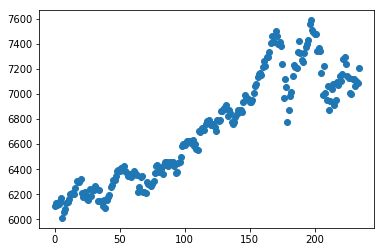

In [15]:
#looking at scatterplot of variables as is
import matplotlib.pyplot as plt
print('NASDAQ')
a=list(range(0,len(NAS)))
plt.scatter(a,NAS)

KOSDAQ


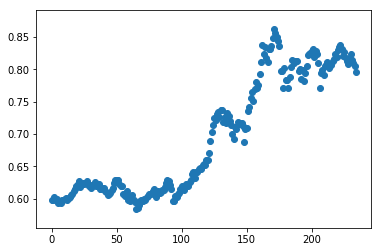

In [16]:
#looking at scatterplot of variables as is
import matplotlib.pyplot as plt
print('KOSDAQ')
b=list(range(0,len(KOS)))
plt.scatter(b,KOS)

Bitcoin


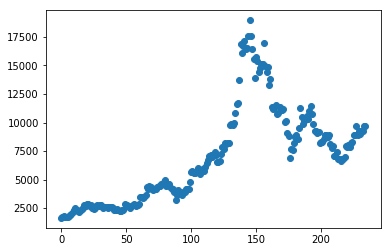

In [17]:
#looking at scatterplot of variables as is
import matplotlib.pyplot as plt
print('Bitcoin')
c=list(range(0,len(BTC)))
plt.scatter(c,BTC)

Impressions


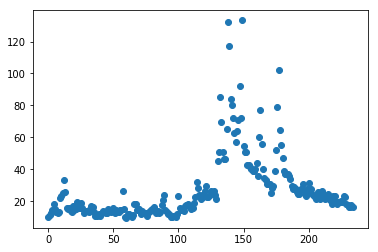

In [18]:
#looking at scatterplot of variables as is
import matplotlib.pyplot as plt
print('Impressions')
d=list(range(0,len(IMP)))
plt.scatter(d,IMP)

It appears each variable has a a serious uptrend and then varying degrees of decline hence why I believe this may be a decent model. However, the scarcity of points for the uptrend in "impressions" will likely present accuracy issues in the model.

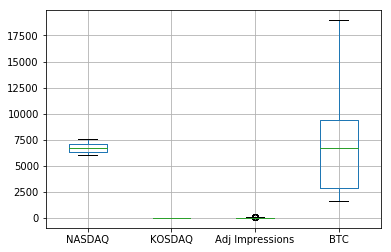

In [19]:
df.boxplot()

C:\Users\tuleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  This is separate from the ipykernel package so we can avoid doing imports until


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000238820EB9B0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x0000023883A42860>]], dtype=object)

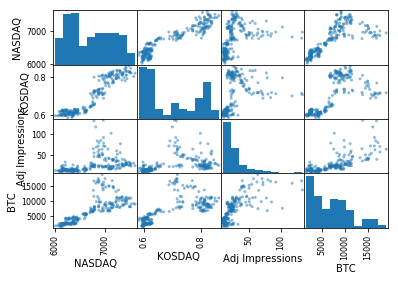

In [20]:
from pandas.tools.plotting import scatter_matrix 
#using scatter_matrix
scatter_matrix(df)

Clearly we need to standardize data (very obvious from looking at boxplot) as data varies in scale so much the boxplots are distorted. Furthermore, it appears from the scatterplot that there is a linear correlation between the NASDAQ and KOSDAQ (reasonable to believe). And a non-linear relationship between BTC and both the NASDAQ and KOSDAQ. Looking at the plots of the dataset, the NASDAQ was correlated to BTC until just after December when BTC plummetted while the NASDAQ rebounded early. Looking at the plot from the dataset of Impressions, again, impressions are most accurate around the peak of BTC, but poor beyond that time. The fault with the impressions could be that google scales searches for key word / total searches and then normalizes the data to a 1 to 100 range that was adjusted here as best as possible but still looks to be non correlated, at least linearly, with BTC even though the overall plots look similar. 

Knowing these variables should be standardized, we'll try and model them anyway.
Using NASDAQ, KOSDAQ, and Impressions we'll try and estimate Bitcoin

In [21]:
y=df['BTC']
X=df[['NASDAQ','KOSDAQ','Adj Impressions']]
size=235#size of df
X.head()

,NASDAQ,KOSDAQ,Adj Impressions
0,6102.7,0.59835,10.000000
1,6129.1,0.59769,11.666667
2,6116.0,0.60225,12.333333
3,6121.2,0.59867,14.666667
4,6149.7,0.60020,18.000000


In [22]:
#splitting features
X_train = X[0:int(size*0.8)]
X_test = X[int(size*0.8):]

#splitting sales (target)
#note y and x have same size (both from df)
y_train = y[0:int(size*0.8)]
y_test = y[int(size*0.8):]

Any an important note for the splitting of testing and training data is that the collected data ranges from May of 2017 to May of 2018 and therefore the model has a full year of data to model itself after--this accounts for seasonal trends. 

In [23]:
regr= LinearRegression()
#training model with training sets of data
regr.fit(X_train, y_train)
# The coefficients
print('Coefficients: \n', regr.coef_)
# The mean square error
print("Residual sum of squares: %.2f"
      % np.mean((regr.predict(X_test) - y_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Variance score: %.2f' % regr.score(X_test, y_test))

Coefficients: 
 [  9.21610770e+00  -1.46012733e+04   9.30240243e+01]
Residual sum of squares: 3584298.68
Variance score: -1.54


In [24]:
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
#redoing R^2
regr = LinearRegression(normalize=True)
regr.fit(X_train, y_train)
Ypred = regr.predict(X_test)
print('Coefficients: \n', regr.coef_)

print("Mean squared error: %.2f"
      % mean_squared_error(y_test, Ypred))
#R^2 score
print('R^2 score: %.2f' % r2_score(y_test, Ypred))

Coefficients: 
 [  9.21610770e+00  -1.46012733e+04   9.30240243e+01]
Mean squared error: 3584298.68
R^2 score: -1.54


Text(0,0.5,'BTC')

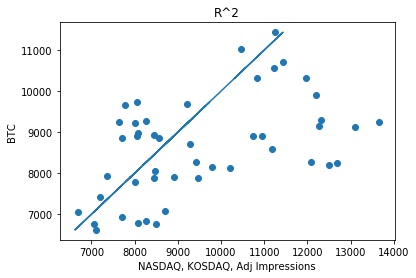

In [25]:
plt.title('R^2')
plt.scatter(regr.predict(X_test),y_test)
plt.plot(y_test,y_test)
plt.xlabel('NASDAQ, KOSDAQ, Adj Impressions')
plt.ylabel('BTC')

Clearly this looks terrible with an incredibly low R^2 value and based on the above plot. The scatterplots of each individual variable suggest the relationship isn't linear anyway. 

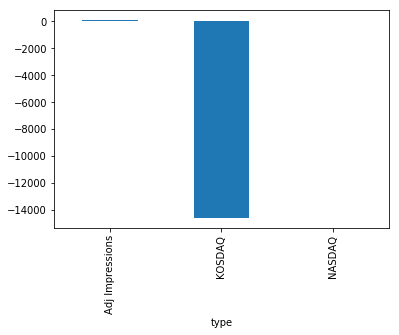

In [26]:
#To measure importance of features in the model we can look at the regression coefficients. However, we need to check if they
#are standardized in order to accurately judge their importance (different units and different scales will throw off measurement)

df = pd.DataFrame({'type':['NASDAQ','KOSDAQ','Adj Impressions'], 'coef':regr.coef_})
df.groupby('type')['coef'].mean().plot(kind='bar')

Again, this looks horrible because the most important coefficient appears to be the KOSDAQ almost exclusively, but we could see visually from the individual scatter plots for the variables that they appeared to be at least somewhat correlated. So we'll now standardize and repeat. 

Normalized Coefficients: 
 [ 0.83910491 -0.23417065  0.66463151]
Normalized Residual sum of squares: 0.02
Normalized Variance score: 0.69
Normalized Coefficients: 
 [ 0.83910491 -0.23417065  0.66463151]
Normalized Mean squared error: 0.02
Normalized R^2: 0.69


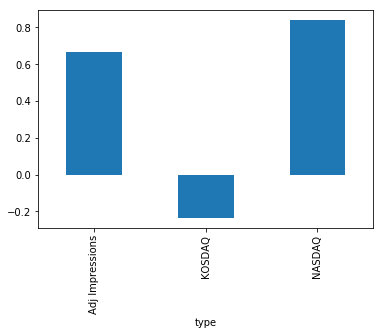

In [27]:
#standardizing variables
df2=pd.read_csv("/Users/tuleg/Documents/python-introduction-MohiAhmed/data2.csv")
df3=df2.drop(['Date'], axis=1)
df3.head()
df3_norm = (df3 - df3.mean()) / (df3.max() - df3.min()) #standardizing vars
#Redoing with standardization
ynorm=df3_norm['BTC']
Xnorm=df3_norm[['NASDAQ','KOSDAQ','Adj Impressions']]

#Splitting into test and train again,
sizen = float(len(Xnorm))
Xnorm_train = Xnorm[0:int(sizen*0.8)]
Xnorm_test = Xnorm[int(sizen*0.2):]
ynorm_train = ynorm[0:int(sizen*0.8)]
ynorm_test = ynorm[int(sizen*0.2):]

#Regression
regrnorm = LinearRegression()
regrnorm.fit(Xnorm_train, ynorm_train)
ynorm_pred = regrnorm.predict(Xnorm_test)

# The coefficients
print('Normalized Coefficients: \n', regrnorm.coef_)
# The mean square error
print("Normalized Residual sum of squares: %.2f"
      % np.mean((regrnorm.predict(Xnorm_test) - ynorm_test) ** 2))
# Explained variance score: 1 is perfect prediction
print('Normalized Variance score: %.2f' % regrnorm.score(Xnorm_test, ynorm_test))

#coefficients, MSE, and R^2 again 
print('Normalized Coefficients: \n', regrnorm.coef_)
print("Normalized Mean squared error: %.2f"
      % mean_squared_error(ynorm_test, ynorm_pred))
#R^2
print('Normalized R^2: %.2f' % r2_score(ynorm_test, ynorm_pred))

regrnorm.coef_
df4_norm = pd.DataFrame({'type':['NASDAQ','KOSDAQ','Adj Impressions'], 'coef':regrnorm.coef_})
df4_norm.groupby('type')['coef'].mean().plot(kind='bar')
#This now shows NASDAQ as the most important coefficient which is more
#accurate because the coefficients were normalized to achieve this

Looking at normalized data in scatterplots

In [28]:
NASnorm=df3_norm['NASDAQ']
KOSnorm=df3_norm['KOSDAQ']
BTCnorm=df3_norm['BTC']
IMPnorm=df3_norm['Adj Impressions']

NASDAQ


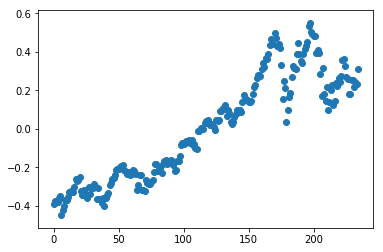

In [29]:
#looking at normalized scatterplot of variables as is
import matplotlib.pyplot as plt
print('NASDAQ')
a2=list(range(0,len(NASnorm)))
plt.scatter(a,NASnorm)

KOSDAQ


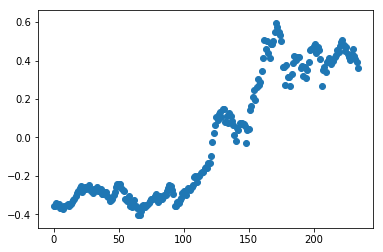

In [30]:
#looking at normalized scatterplot of variables as is
print('KOSDAQ')
b2=list(range(0,len(KOSnorm)))
plt.scatter(b,KOSnorm)

Impressions


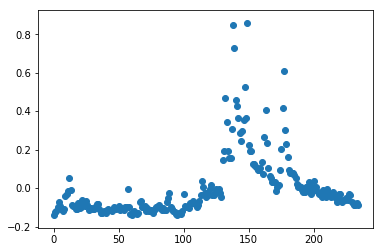

In [31]:
#looking at normalized scatterplot of variables as is
import matplotlib.pyplot as plt
print('Impressions')
c2=list(range(0,len(IMPnorm)))
plt.scatter(c2,IMPnorm)

Bitcoin


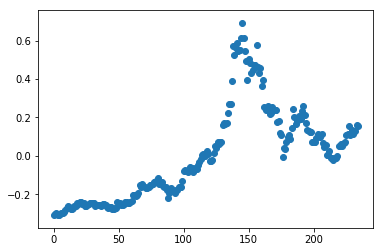

In [32]:
#looking at normalized scatterplot of variables as is
import matplotlib.pyplot as plt
print('Bitcoin')
d2=list(range(0,len(BTCnorm)))
plt.scatter(d2,BTCnorm)

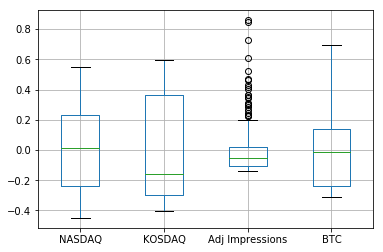

In [35]:
df3_norm.boxplot()

Notice that the shape and trends have been completely retained but just now are of the same scale. They are standardized so now they can be compared properly.

C:\Users\tuleg\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.scatter_matrix' is deprecated, import 'pandas.plotting.scatter_matrix' instead.
  """Entry point for launching an IPython kernel.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000023883E324E0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x00000238841E6EF0>]], dtype=object)

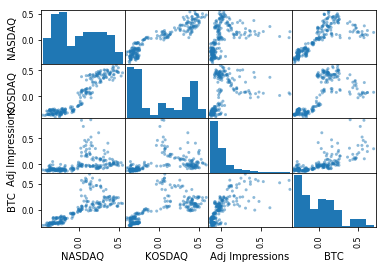

In [34]:
scatter_matrix(df3_norm)

Looking at the new scatterplot with normalized data we can see vaguely linear correlation between NASDAQ and BTC and KOSDAQ. KOSDAQ does not correlate well in the middle and Adj Impressions appear to have a steep linear or steep logarithmic trend.

Text(0,0.5,'BTC')

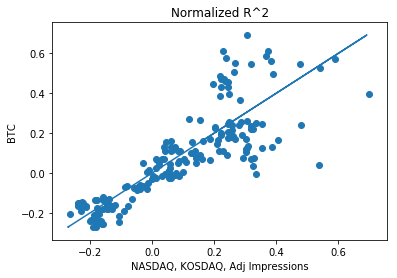

In [36]:
plt.title('Normalized R^2')
plt.scatter(regrnorm.predict(Xnorm_test),ynorm_test)
plt.plot(ynorm_test,ynorm_test)
plt.xlabel('NASDAQ, KOSDAQ, Adj Impressions')
plt.ylabel('BTC')

Let's the same thing, but with k fold cross validation!

In [37]:
# fit a model
lm = linear_model.LinearRegression()
model = lm.fit(Xnorm_train, ynorm_train)
initpredictions = lm.predict(Xnorm_test)

Score: 0.694821344173


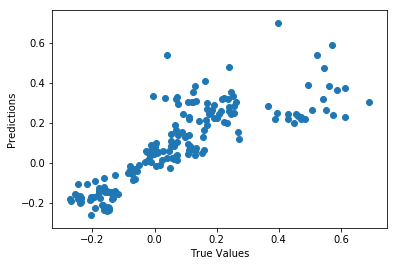

In [38]:
plt.scatter(ynorm_test, initpredictions)
plt.xlabel('True Values')
plt.ylabel('Predictions')
print ('Score:', model.score(Xnorm_test, ynorm_test))

Cross validating

In [39]:
from sklearn.model_selection import KFold # import KFold
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
# Perform 5-fold cross validation
kfoldscores = cross_val_score(model, Xnorm, ynorm, cv=5)
print('Cross-validated scores:', kfoldscores)

Cross-validated scores: [-7.86204781 -0.94376622  0.84837732 -0.43481703 -1.54267713]


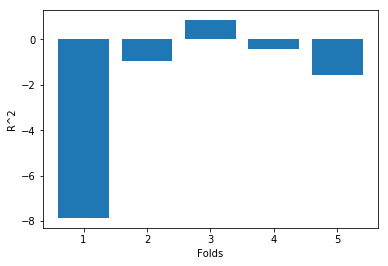

In [40]:
plt.xlabel('Folds')
plt.ylabel('R^2')

plt.bar(range(1,6),kfoldscores)
plt.show()

These K folds don't look promising. Cross validation made our model much worse compared to before.
But let's use it to predict and see what happens

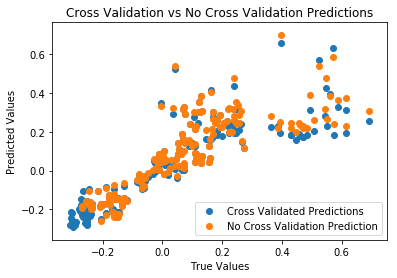

In [41]:
kfoldpredict=cross_val_predict(model,Xnorm,ynorm,cv=5)

cross=plt.scatter(ynorm,kfoldpredict)
plt.xlabel('True values')
plt.ylabel('Predicted Values')
#Looking at the two plot

nocross=plt.scatter(ynorm_test,initpredictions)
plt.title('Cross Validation vs No Cross Validation Predictions')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.legend((cross, nocross),
           ('Cross Validated Predictions', 'No Cross Validation Prediction'),loc='lower right')

Text(0,0.5,'BTC')

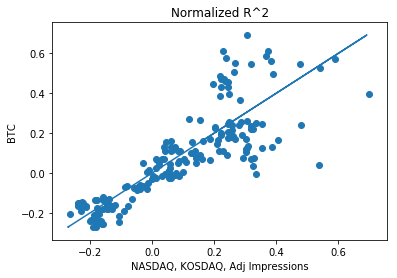

In [42]:
#Recall
plt.title('Normalized R^2')
plt.scatter(regrnorm.predict(Xnorm_test),ynorm_test)
plt.plot(ynorm_test,ynorm_test)
plt.xlabel('NASDAQ, KOSDAQ, Adj Impressions')
plt.ylabel('BTC')

The K fold validation does not seem to yield what could be called an obvious improvement. Recall the normalized R^2 scatterplot prior to cross validation. This looks much better than previously seen, but it is clear the linear model is not encapsulating the downward trend towards the end of the data. The data looks like it has more of a natural log trendline. So we'll try that in the future.

Let's repeat linear regression with gridsearchcv

In [92]:
from sklearn.model_selection import GridSearchCV

model2 = linear_model.LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model2,parameters, cv=3)
grid.fit(Xnorm_train, ynorm_train)
print ("r2 / variance : ", grid.best_score_)
print("Residual sum of squares: %.2f" % np.mean((grid.predict(Xnorm_test) - ynorm_test) ** 2))

r2 / variance :  -2.13986821684
Residual sum of squares: 0.02


Something must be wrong for the r2/variance to be so extremely low when previously the linear model could predict with an R^2 of .69:

In [94]:
model3 = linear_model.LinearRegression()
model3.fit(Xnorm_train, ynorm_train)
predictions = model3.predict(Xnorm_test)
print ("r2/variance : ", model3.score(Xnorm_test,ynorm_test))
print("Residual sum of squares: %.2f"
              % np.mean((model3.predict(Xnorm_test) - ynorm_test) ** 2))

r2/variance :  0.694821344173
Residual sum of squares: 0.02


One final piece, we'll combine NASDAQ with Adj Impressions into a new variable and see if that improves the model

In [109]:
df5=df3
df5['Combo']=df5['NASDAQ']*df5['Adj Impressions']
df5.head()

,NASDAQ,KOSDAQ,Adj Impressions,BTC,Combo
0,6102.7,0.59835,10.000000,1639.3,61027.000000
1,6129.1,0.59769,11.666667,1756.8,71506.166687
2,6116.0,0.60225,12.333333,1807.4,75430.666646
3,6121.2,0.59867,14.666667,1677.0,89777.600020
4,6149.7,0.60020,18.000000,1697.4,110694.600000


In [110]:
#Normalize again
df5_norm = (df5 - df5.mean()) / (df5.max() - df5.min()) #standardizing vars
#Redoing with standardization
y5norm=df5_norm['BTC']
X5norm=df5_norm[['NASDAQ','KOSDAQ','Adj Impressions','Combo']]

In [111]:
#Splitting into test and train again,
sizen = float(len(Xnorm))
X5norm_train = X5norm[0:int(sizen*0.8)]
X5norm_test = X5norm[int(sizen*0.2):]
y5norm_train = y5norm[0:int(sizen*0.8)]
y5norm_test = y5norm[int(sizen*0.2):]

#there is no model 4, calling it model 5 for continuity reasons and lack of creativity
model5 = linear_model.LinearRegression()
model5.fit(X5norm_train, y5norm_train)
predictions = model5.predict(X5norm_test)
print ("r2: ", model5.score(X5norm_test,y5norm_test))
print("Residual sum of squares: %.2f"
              % np.mean((model5.predict(X5norm_test) - y5norm_test) ** 2))

r2:  0.703065279522
Residual sum of squares: 0.02


A small improvement in R2! 

Text(0,0.5,'BTC')

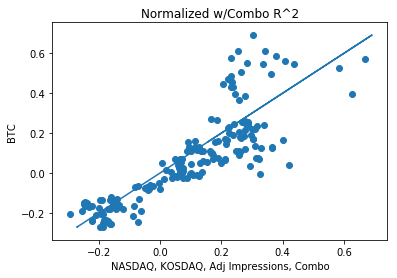

In [117]:
#Recall
plt.title('Normalized w/Combo R^2')
plt.scatter(model5.predict(X5norm_test),y5norm_test)
plt.plot(y5norm_test,y5norm_test)
plt.xlabel('NASDAQ, KOSDAQ, Adj Impressions, Combo')
plt.ylabel('BTC')

Now we'll look at the Random Forest 

Recall the normalized R^2 scatterplot prior to cross validation. This looks much better than the previously seen plot for the non-normalized data, but it is clear the linear model is not encapsulating the downward trend towards the end of the data. The data looks like it has more of a natural log trendline. So we might want to try that in the future,
But first we'll look at the required Random Forest regression: 

In [43]:
# Using Skicit-learn to split data into training and testing sets
#setting y to be the y variable in the dataframe
yrf=df3_norm['BTC']

#setting X to be all other features
Xrf=df3_norm.drop(['BTC'], axis=1)
#size of X and y
size=235

#splitting features
Xrf_train, Xrf_test, yrf_train, yrf_test = train_test_split( Xrf, yrf, test_size=0.2, random_state=42)
#
df3_norm.head()

,NASDAQ,KOSDAQ,Adj Impressions,BTC
0,-0.391571,-0.353936,-0.138001,-0.308472
1,-0.374831,-0.356312,-0.124534,-0.301689
2,-0.383138,-0.339897,-0.119147,-0.298768
3,-0.379840,-0.352784,-0.100293,-0.306296
4,-0.361769,-0.347277,-0.073359,-0.305118


Establishing a baseline. We will look at the historical average price of bitcoin. This way, we know if our model is useful or if we would have been better of guessing the average price.

In [44]:
BTCmean=np.mean(BTC)
BTCnormmean=np.mean(BTCnorm)
print('Average Bitcoin Price:', BTCmean)
print('Average Normalized Bitcoin Price:',BTCnormmean)
#note these are two different averages because one is for the normalized data
# The baseline prediction is the average price

#baseline_errors = abs(BTCmean - yrf_test)
baseline_norm_errors=abs(BTCnormmean-yrf_test)
#print('Average baseline error: ', round(np.mean(baseline_errors), 2))
print('Average normalized baseline error: ', round(np.mean(baseline_norm_errors), 2))

Average Bitcoin Price: 6982.563829787233
Average Normalized Bitcoin Price: 7.653452339969164e-17
Average normalized baseline error:  0.2


Training the Random Forest Model

In [45]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)
# Train the model on training data
rf.fit(Xrf_train, yrf_train);

In [46]:
rf_predictions=rf.predict(Xrf_test)

#calculating the error
rf_error=abs(rf_predictions-yrf_test)

# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(rf_error), 2))


Mean Absolute Error: 0.04


Previously we saw that the Average normalized baseline error was 0.2 (using the average price of bitcoin), but when we use our model we're only getting an average error of 0.04! 

Calculating Accuracy

In [47]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (rf_error / yrf_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 79.46 %.


~80% accuracy looks pretty good! 

In [48]:
from sklearn.metrics import r2_score
rf_predicted_train=rf.predict(Xrf_train)
rf_predicted_test=rf.predict(Xrf_test)

rf_test_score=r2_score(yrf_test, rf_predicted_test)

print('Test Data R^2 Score:', rf_test_score)

Test Data R^2 Score: 0.94490520876


An R^2 of .94 is a little concerning because it is high enough to consider that our model with random forest regression is likely overfitting the data.
To correct this, we'd need a tuning parameter

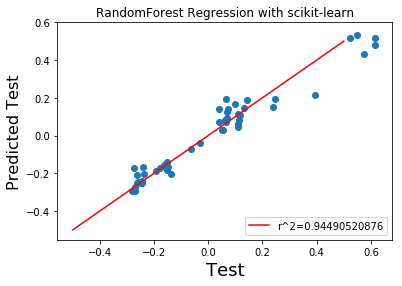

In [118]:
plt.scatter(yrf_test, rf_predicted_test)
#plt.plot(np.arange(8, 15), np.arange(8, 15), label="r^2=" + str(r2), c="r")
#plt.legend(loc="lower right")
#plt.title("RandomForest Regression with scikit-learn")
#plt.show
plt.plot(np.arange(-0.5, 1.5), np.arange(-0.5, 1.5), label='r^2=' + str(rf_test_score), c="r")
plt.legend(loc="lower right")
plt.title("RandomForest Regression with scikit-learn")
plt.xlabel('Test', fontsize=18)
plt.ylabel('Predicted Test', fontsize=16)
plt.show()

Now let's do Ridge Regression (as opposed to LASSO) since there are only 3 features used to predict BTC and they all seem to correlate to some degree it would not be ideal if one was completely eliminated.


In [ ]:
#So we have 2 models to use RF and a few different linear models
#Rf model is rf.predict
#linear model is model.predict (.69 R^2) and model5.predict(.7 R^2)

In [112]:
#saving models as pickes
#Saving rf model
import pickle
with open('RFregression.pkl', 'wb') as fid:
    pickle.dump(rf, fid,2) 
#creating feature vector and convert user input into dummy var    
#Create a Dataframe with only the dummy variables
user_rf = df3_norm.drop('BTC',axis=1)
index_dict = dict(zip(user_rf.columns,range(user_rf.shape[1])))

with open('user_rf', 'wb') as fid:
    pickle.dump(index_dict, fid,2)  

In [113]:
import pickle
with open('LINregression1.pkl', 'wb') as fid:
    pickle.dump(model, fid,2) 
#creating feature vector and convert user input into dummy var    
#Create a Dataframe with only the dummy variables
user_lin = df3_norm.drop('BTC',axis=1)
index_dict2 = dict(zip(user_lin.columns,range(user_lin.shape[1])))

with open('user_lin1', 'wb') as fid:
    pickle.dump(index_dict2, fid,2)  

In [114]:
import pickle
with open('LINregression2.pkl', 'wb') as fid:
    pickle.dump(model5, fid,2) 
#creating feature vector and convert user input into dummy var    
#Create a Dataframe with only the dummy variables
user_lin2 = df5_norm.drop('BTC',axis=1)
index_dict3 = dict(zip(user_lin2.columns,range(user_lin2.shape[1])))

with open('user_lin2', 'wb') as fid:
    pickle.dump(index_dict3, fid,2)  

# Please ignore the following, it was an attempt at Ridge regression that was not debugged in time

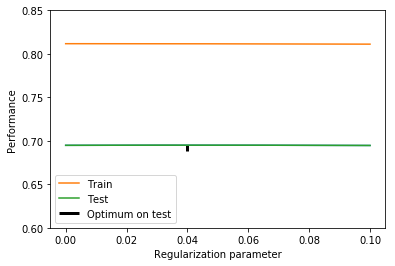

In [65]:
ridgetrain_errors=[]
ridgetest_errors=[]
# Fill these in
#plot is better with this logspace
alphas = np.logspace(-8,-1,1000)
from sklearn.linear_model import Ridge
ridgescores = []

for alpha in alphas:
    #need max_iter > 1000 in order to converge
    ridgeregr = Ridge(alpha=alpha, max_iter=5000)
        
    #train the model with training data
    ridgeregr.fit(Xnorm_train, ynorm_train)
    #training errors are within the loop
    ridgetrain_errors.append(ridgeregr.score(Xnorm_train, ynorm_train))
    ridgescores.append(ridgeregr.score(Xnorm_test,ynorm_test))
    
    
plt.plot(alphas,ridgescores)

#test errors outside the loop
ridgetest_errors=ridgescores

#optimum alpha value based on Ridge
alpha_optim=alphas[np.argmax(ridgescores)]

#given code
plt.plot(alphas, ridgetrain_errors, label='Train')
plt.plot(alphas, ridgetest_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(ridgetest_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0.6, .85])
plt.xlabel('Regularization parameter')
plt.ylabel('Performance')

plt.show()


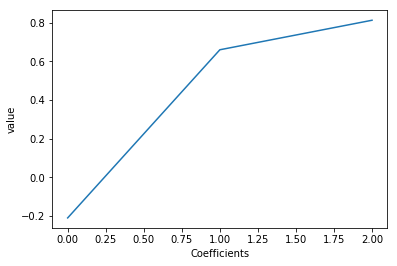

In [66]:
#plotting just optimum coeff
#regropt defined as Ridge of just the optimum alpha's
regropt = Ridge(alpha=alpha_optim, max_iter=5000)

#fit to training
regropt.fit(Xnorm_train, ynorm_train)
#taking coeffs, sorting so that it is clear just how many are set to 0 (excluded by LASSO)
opt_coeff=np.sort(regropt.coef_)

plt.plot(opt_coeff)

plt.xlabel('Coefficients')
plt.ylabel('value')
plt.show()

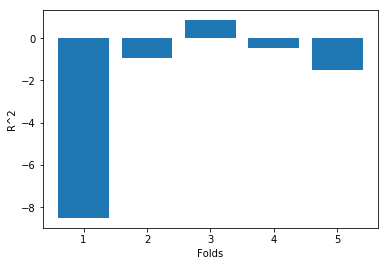

In [67]:
from sklearn.model_selection import cross_val_score
regropt = Ridge(alpha=alpha_optim, max_iter=1500)

#X and Y were already computed during random forest
ridgeX=Xrf
ridgeY=yrf
#using cross_val_score to do 5 fold cross validation of data
scoresopt=cross_val_score(regropt, ridgeX, ridgeY, cv=5)

plt.xlabel('Folds')
plt.ylabel('R^2')

plt.bar(range(1,6),scoresopt)
plt.show()

In [81]:
from sklearn.cross_validation import KFold
from sklearn import preprocessing
def run_cv_coeffs(ridgeX,ridgeY,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(ridgeY),n_folds=5,shuffle=True)
    y_pred = ridgeY.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        Xnorm_train, Xnorm_test = ridgeX[train_index], ridgeX[test_index]
        ynorm_train = ridgeY[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(Xnorm_train,ynorm_train)
        y_pred[test_index] = clf.predict(Xnorm_test)
        coeffs.append(clf.coef_)
    return coeffs



scaler = preprocessing.StandardScaler()
X_scaled = ridgeX.as_matrix().astype(np.float)
X_scaled = scaler.fit_transform(ridgeX)
#changed alpha=alpha_best to alpha_optim
coeffs=run_cv_coeffs(X_scaled,np.array(ridgeY),Ridge,alpha=alpha_optim)

In [82]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(ridgeX.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(ridgeX.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

In [83]:
dfCoeffs = pd.DataFrame({'type':ridgeX.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]
plt.figure(figsize=(15,15))
#df_Coeffs.sort produced an error, fixed by changing it to dfCoeffs.sort_values
dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values
#dfCoeffs_sorted.plot(ridgeX='type',ridgeY='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))
dfCoeffs.head()

#can't determine why dfCoeffs is empty hence why we cannot plot dfCoeffs_sorted.plot...

,coef,std,type
